<a href="https://colab.research.google.com/github/yustiks/retina_transfer_learning/blob/master/Webcam_pliers_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📸 Predict tools with webcam


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# I have no idea who is the author of the code
# in this cell that saves an image from a webcam
# inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [4]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5274 (delta 2), reused 1 (delta 0), pack-reused 5264
Receiving objects: 100% (5274/5274), 13.29 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (3521/3521), done.


In [5]:
%cd keras-retinanet/

/content/keras-retinanet


In [6]:
!git checkout 42068ef9e406602d92a1afe2ee7d470f7e9860df

Note: checking out '42068ef9e406602d92a1afe2ee7d470f7e9860df'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 42068ef Merge pull request #621 from borakrc/fix-anchor-boxes-not-shown


In [7]:
!pip install .

Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.4.1-cp36-cp36m-linux_x86_64.whl size=156005 sha256=5b0d6e4de8bb76aebea657de0252f42406e94541dcf25ce55d27cf7e2c65db78
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20485 sha256=961848e1538be74ff71187668a9545b1699cec8ee9afb4d9d46a5ef185008a19
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [9]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:

import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [11]:
#!/usr/bin/env python
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())


Using TensorFlow backend.


In [0]:

def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [13]:

%%time
keras.backend.tensorflow_backend.set_session(get_session())
path_to_model='/content/drive/My Drive/resnet50_csv_20_KTH.h5'
backbone='resnet50'
# load the model
print('Loading model, this may take a second...')
model = models.load_model(path_to_model, backbone_name=backbone, convert=True)

Loading model, this may take a second...












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



CPU times: user 14.1 s, sys: 1.47 s, total: 15.6 s
Wall time: 34 s


In [0]:
labels_to_names = {1: 'зубило',2:'молоток',3:'плоскогубцы',4:'гаечный ключ'}

In [0]:
from PIL import ImageFont, ImageDraw
fontpath = "/content/drive/My Drive/wqy-zenhei.ttf"
font = ImageFont.truetype(fontpath, 14)

In [0]:
def draw_online(img):
  draw = img.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(img)
  image, scale = resize_image(img)

  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  #boxes, scores = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
  #for box, score  in zip(boxes[0], scores[0]):
      # scores are sorted so we can break
      #print (score[0],len(score))
      if score < 0.81:
          break

      #label=0   
      #color = label_color(label)
      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      #draw_caption(draw, b, caption)
      img_pil = Image.fromarray(draw)
      draw_ = ImageDraw.Draw(img_pil)
      draw_.text((b[0], b[1] - 15),  caption, font = font)
      draw = np.array(img_pil)
      draw1 = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
      #cv2.imwrite('/content/drive/My Drive/retina/' + str(i) + '.jpg', draw1)

  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw1)
  plt.show()

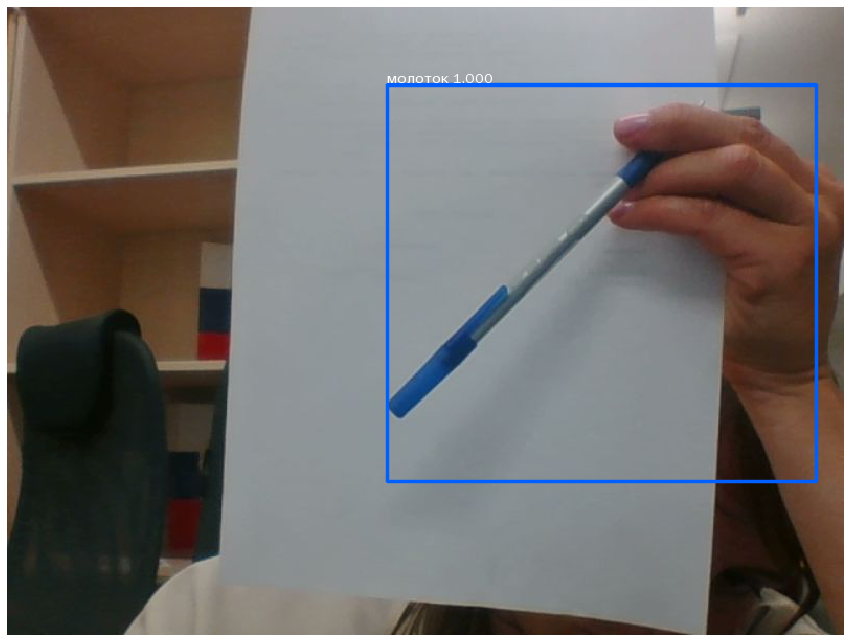

In [22]:
img = take_photo()
draw_online(img)
